Projet description: In this project we will use Generative adversarial networks to stylize images to resemble the paintings of Monet.
We will be training a model on provided Monet paintings (300 of them) and generating monetified versions of the photos.

So the data we are working on is in Monet paintings sized 256x256 in JPEG format (or tfrec).
photo_tfrec - 7028 photos sized 256x256 in TFRecord format.
photo_jpg - 7028 photos sized 256x256 in jpeg.

Desired output - for the kaggle competition we would like to stylize all the provided photos, but in this notebook we will limit this number to 5 due to the large amount of time required for the model to run.


Lets start with the code. Basic imports.

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch as T
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [13]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")

Now we can upload the data and perform some EDA.
I will stick to using the jpg format files due to their familiarity.

For this type of task, performing an EDA may be fairly complex, as our data is largely dependent on image quality.
I will stick to performing color distribution analysis as it is are most important when working with visual arts.

Potentially, the EDA could be enhanced with noise analysis. 

In [14]:
monet_df = []
for root,_, files in os.walk('./data/monet_jpg'):
    for filename in files:
        path = os.path.join(root+'/'+filename)
        monet_df.append(path)

monet_df = pd.DataFrame(monet_df, columns=['filename'])

In [15]:
print(f"Number of Monet Images: {monet_df.shape[0]}")

Number of Monet Images: 300


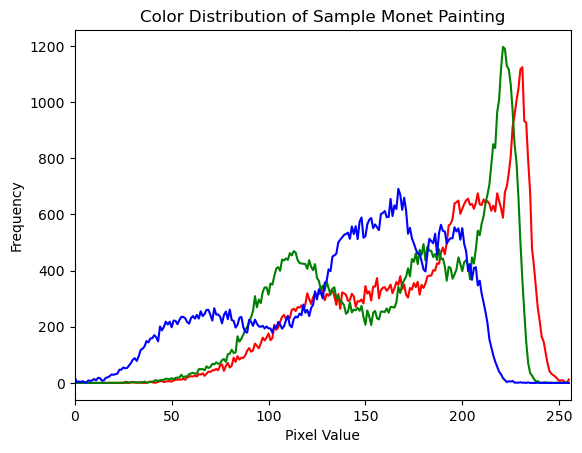

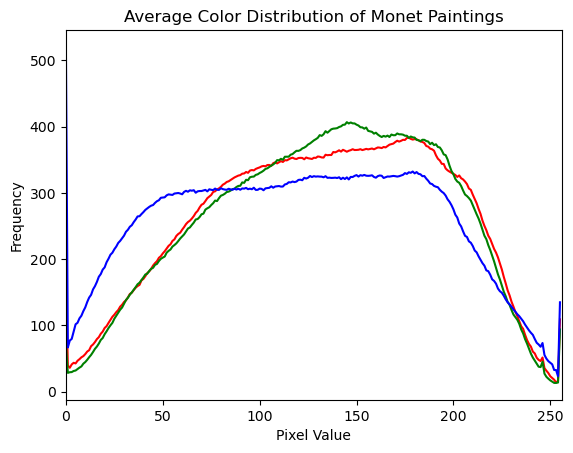

In [16]:
# Function to calculate color histogram
import cv2
import matplotlib.pyplot as plt

def calculate_color_histogram(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    color = ('r', 'g', 'b')
    histogram = {}
    for i, col in enumerate(color):
        histogram[col] = cv2.calcHist([image], [i], None, [256], [0, 256])
    return histogram

# Function to plot color histogram
def plot_color_histogram(histogram, title):
    plt.figure()
    for col in histogram:
        plt.plot(histogram[col], color=col)
        plt.xlim([0, 256])
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Calculate and plot color histogram for a sample image
sample_image_path = monet_df['filename'].iloc[0]
sample_histogram = calculate_color_histogram(sample_image_path)
plot_color_histogram(sample_histogram, 'Color Distribution of Sample Monet Painting')

# Calculate average color histogram for the dataset
average_histogram = {'r': np.zeros((256, 1)), 'g': np.zeros((256, 1)), 'b': np.zeros((256, 1))}

for image_path in monet_df['filename']:
    histogram = calculate_color_histogram(image_path)
    for col in average_histogram:
        average_histogram[col] += histogram[col]

# Normalize the average histogram
num_images = len(monet_df)
for col in average_histogram:
    average_histogram[col] /= num_images

# Plot the average color histogram
plot_color_histogram(average_histogram, 'Average Color Distribution of Monet Paintings')

In [17]:
photo_df = []
for root,_, files in os.walk('./data/photo_jpg'):
    for filename in files:
        path = os.path.join(root+'/'+filename)        
        photo_df.append(path)

photo_df = pd.DataFrame(photo_df, columns=['filename'])

In [18]:
print(f"Number of Content Images: {photo_df.shape[0]}")
photo_df = photo_df.sample(5)

Number of Content Images: 7038


Preprocessing the data. We will be applying the data preprocessor each time we transfer styles and exract features.
So we will declare the preprocessor methods before developing the model.

Comments on the preprocessor class are incode.

In [19]:
weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.35,
          'conv4_1': 0.25, 'conv5_1': 0.15}
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


# Layer of interest of the GANs that we are most interested in
LAYERS_OF_INTEREST = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'    
}

class Preprocessing():
    
    def __init__(self, weights, layers):
        # layer importance
        self.weights = weights
        # layer of interest
        self.layers_of_interest = layers
        
    # Passes an input image through a model and extracts features from specific layers.
    def apply_model_and_extract_features(self,image, model):
        
        x = image
        
        features = {}
        
        for name, layer in model._modules.items():
            # Passing the image into the pretrained model
            x = layer(x)
            # Extract features from layers of interest
            if name in LAYERS_OF_INTEREST:
                features[LAYERS_OF_INTEREST[name]] = x

        return features
    # Used in style transfer
    # The Gram matrix is a matrix of inner products (or dot products) of the feature maps extracted from a convolutional neural network (CNN).
    #  It is used to represent the correlations between different feature channels.   
    def calculate_gram_matrix(self,tensor_image):
        _, channels, height, width = tensor_image.size()

        tensor_image = tensor_image.view(channels, height*width)

        gram_matrix = T.mm(tensor_image, tensor_image.t())

        gram_matrix = gram_matrix.div(channels * height * width)

        return gram_matrix
    
    def tensor_to_image(self,image_tensor):

        image = image_tensor.clone().detach()
        image = image.cpu().numpy().squeeze()
        
        # Transpose (C, W, H) -> (W, H, C)
        image = image.transpose(1,2,0)
        # Desnormalize
        image *= np.array(std) + np.array(mean)
        # Convert to 0-255 scale
        image[:,:,0] = image[:,:,0] * 255
        image[:,:,1] = image[:,:,1] * 255
        image[:,:,2] = image[:,:,2] * 255
        image = np.clip(image, 0, 255).astype(np.uint8)
        
        return image
    
    

In [20]:
# Layer importance


preprocessing = Preprocessing(weights, LAYERS_OF_INTEREST)

Selecting the Model. 

There are many models and approaches to solve this sort of task. The most common being Alexnet, Resnet, VggNet.

For this project i chose to use a pretrained vggnet model.

I chose this model because it is a good choice due to its balance of depth and computational efficiency. With 19 layers, it provides a rich feature extraction capability while avoiding the excessive complexity of deeper networks. Its consistent use of small 3x3 convolutional filters allows for detailed and hierarchical feature learning, which contributes to its strong performance in image classification tasks. Additionally, VGG19's architecture is straightforward, making it easy to implement and adapt for various applications, and its proven effectiveness in benchmarks like ImageNet underscores its reliability and robustness.

It is also common and well documented.

VGG model description:


VGGNet is a deep convolutional neural network architecture introduced by the Visual Geometry Group (VGG) at the University of Oxford. It's known for its simplicity and effectiveness in image classification tasks. The main characteristics of VGGNet include:

Depth: VGGNet models come in different depths, such as VGG16 and VGG19, referring to the number of weight layers in the network.

Architecture: The network uses a stack of small (3x3) convolutional filters and 2x2 max-pooling layers. This simple and uniform structure helps capture complex features while maintaining a manageable number of parameters.

Fully Connected Layers: After the convolutional and pooling layers, the network includes several fully connected layers before the output layer for classification.

Performance: VGGNet achieved impressive results in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) and has since been used as a backbone for various tasks and models due to its effective feature extraction capabilities.

In [21]:


transformations = transforms.Compose([
    transforms.Resize((256,256)), # Resize to a (256,256) image
    transforms.ToTensor(),        # Convert to a Tensor
    transforms.Normalize(mean, std) # Normalize
])

vgg = models.vgg19(pretrained=True).features

# Freeze layers
for params in vgg.parameters():
    params.requires_grad_(False)
    
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Lets start with a very simple use case for our model. We will use it as a basic run and later extend on this with hyperparameter tuning.
In this snippet we will transfer the styles and extract features only once. The results will be available in the folder specified in the code.

In [22]:


monet_idx_list = []

for i, img_path in enumerate(photo_df.iloc[:,0]):
    
    print(f"Image number: {i+1}")
    # Load the image
    img = Image.open(img_path)        
    # Apply transformations
    content_image = transformations(img).to(device)
    content_image = content_image.unsqueeze(0)
    
    # Select a random index  
    monet_idx = np.random.randint(0,300, size=1)
    monet_idx_list.append(monet_idx)
    # Load the monet image
    monet_img = Image.open(monet_df.iloc[monet_idx[0],0])
    # Apply transformations
    style_image = transformations(monet_img).to(device)
    style_image = style_image.unsqueeze(0)
    
    # Copy the content of content image into the final image (target)
    target = content_image.clone().requires_grad_(True).to(device)
    
    
    # Loop of performing style transfer
    # Extracting features from content image, style image, and final image
    content_img_features = preprocessing.apply_model_and_extract_features(content_image, vgg)
    style_img_features = preprocessing.apply_model_and_extract_features(style_image, vgg)        
    target_features = preprocessing.apply_model_and_extract_features(target, vgg)
        
        # Compute the content loss
    content_loss = F.mse_loss(target_features["conv4_2"], content_img_features["conv4_2"])

    style_loss = 0
        # Calculate the Gram Matrices of style image
    style_features_gram_matrix = {layer: preprocessing.calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}

    for layer in weights:
            
        target_feature = target_features[layer]
            # Calculate the Gram Matrix of final image
        target_gram_matrix = preprocessing.calculate_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]
            
            # Compute the layer loss
        layer_loss = F.mse_loss(target_gram_matrix, style_gram_matrix)
            # Compute weighted layer loss
        layer_loss *= weights[layer]

        _, channels, height, width = target_feature.shape
            # Add the layer loss to style loss
        style_loss += layer_loss
        
        # Compute total loss
        total_loss = 1000000 * style_loss + content_loss


    
    # Convert final image to an array
    target_img = preprocessing.tensor_to_image(target)
    
    # Save the final image
    target_img = Image.fromarray(target_img)
    

    target_img.save("./data/notuner/" + str(i) + ".jpg")       

Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5


Enhancing the model with parameter hypertuning.
Here we will perform the previously mentioned actions multiple times, (in a loop of 1 to 60) and tune hyper parameters on each run.

Please note that the number of 60 runs is not nearly high enough, and it should be ran in the range of 1000-2000 times for better image quality. 
(Unfortuanetly i'm limited by system specs atm.)

Image number: 1


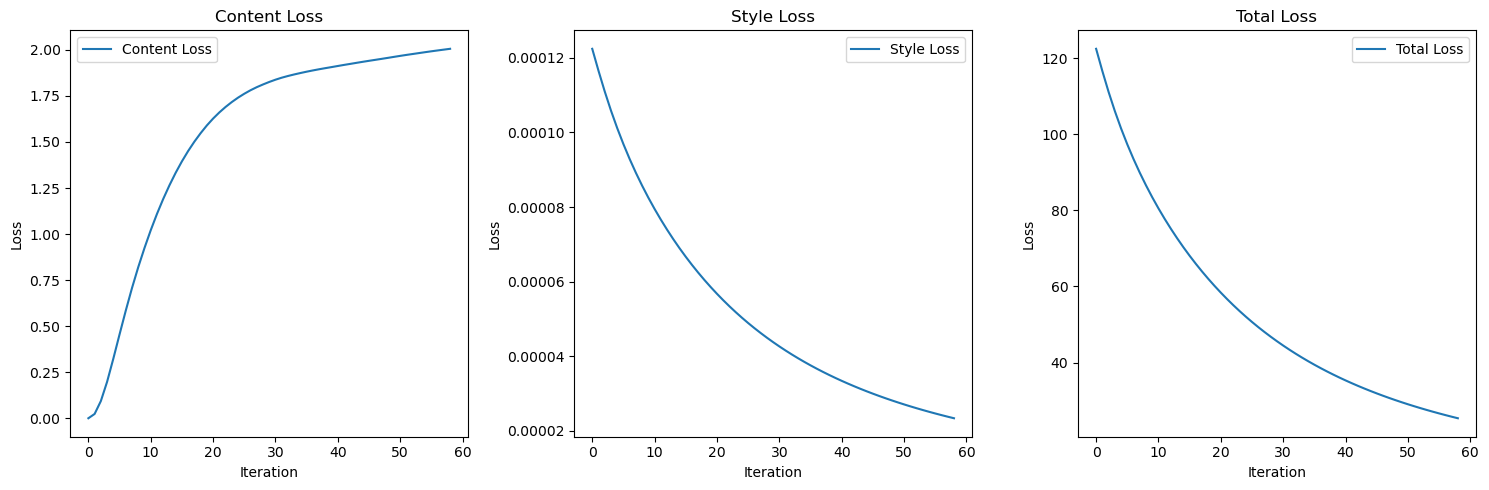

Image number: 2


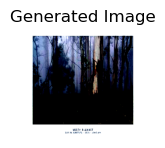

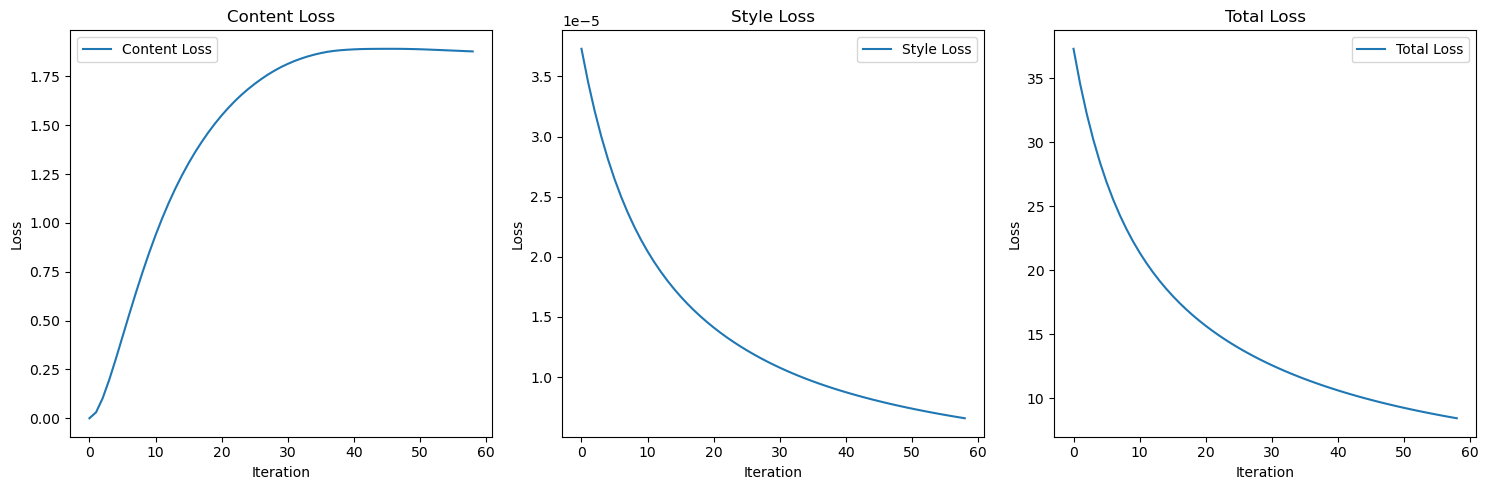

Image number: 3


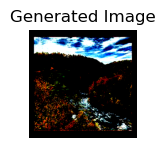

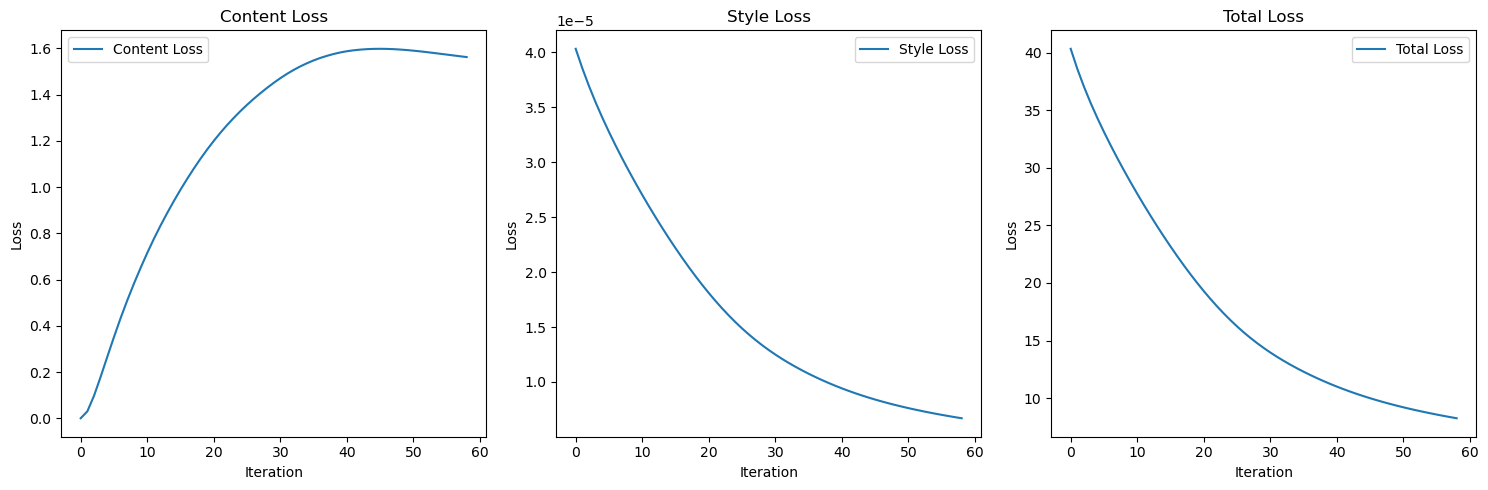

Image number: 4


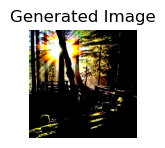

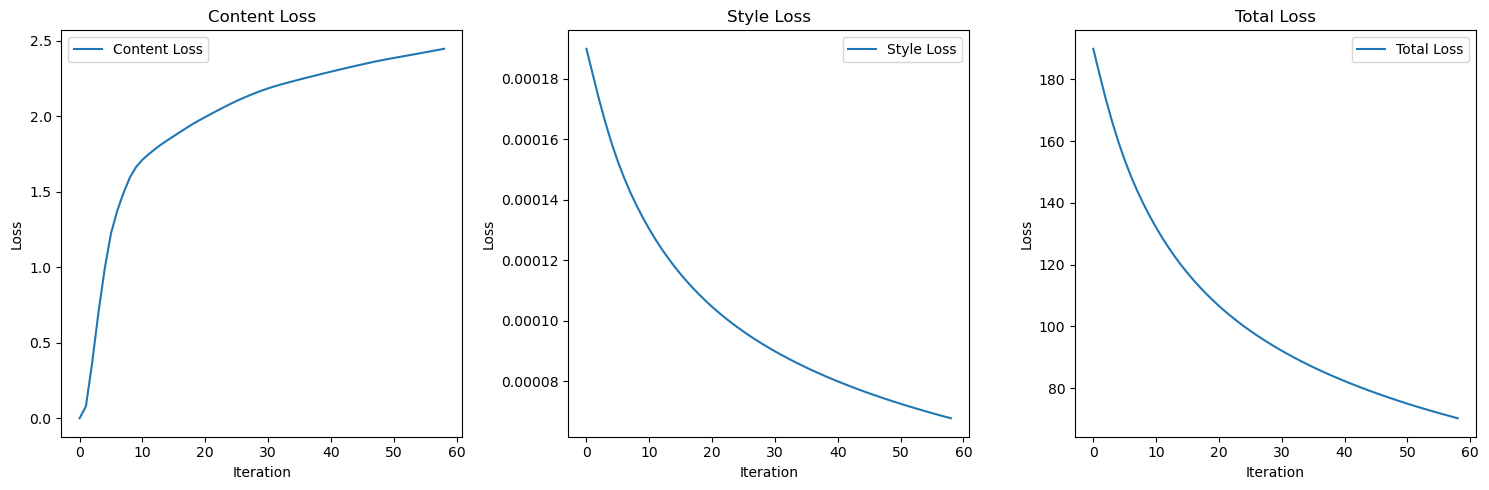

Image number: 5


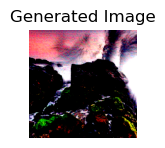

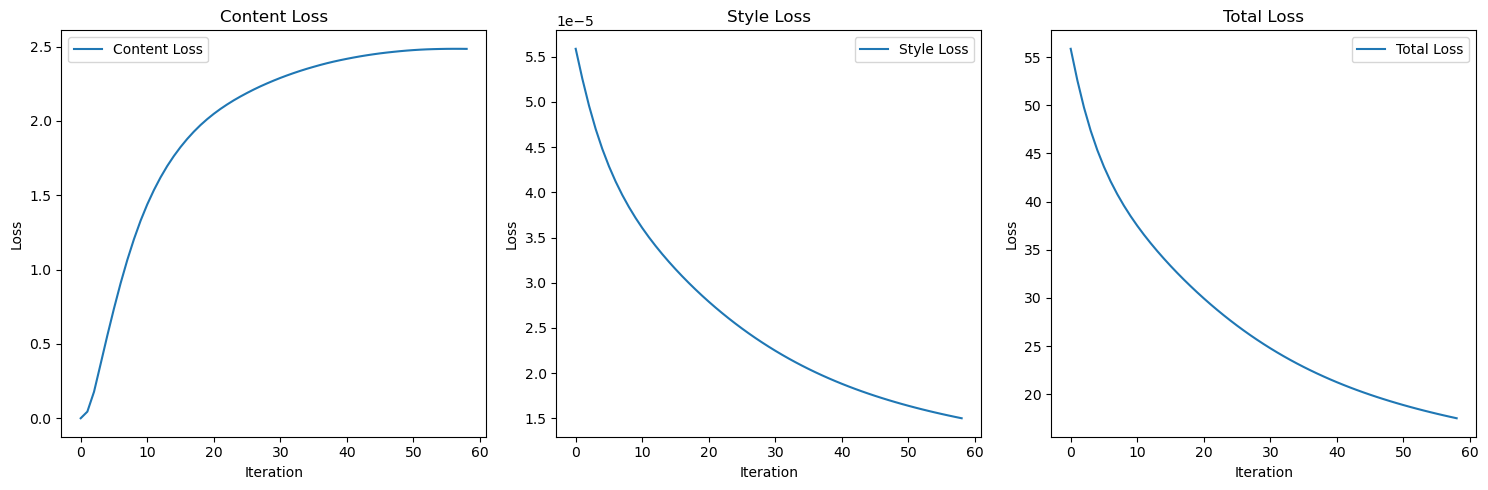

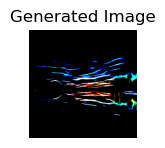

In [23]:
monet_idx_list = []


# Function to update loss plot after processing each image
def update_loss_plot(content_losses, style_losses, total_losses):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(content_losses, label='Content Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Content Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(style_losses, label='Style Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Style Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(total_losses, label='Total Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Total Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.subplot(1, 4, 4)
    plt.imshow(target_img)
    plt.title('Generated Image')
    plt.axis('off')


for i, img_path in enumerate(photo_df.iloc[:, 0]):
    print(f"Image number: {i + 1}")
    
    # Load the image
    img = Image.open(img_path)
    content_image = transformations(img).to(device)
    content_image = content_image.unsqueeze(0)
    
    # Select a random index
    monet_idx = np.random.randint(0, 300, size=1)
    monet_idx_list.append(monet_idx)
    
    # Load the monet image
    monet_img = Image.open(monet_df.iloc[monet_idx[0], 0])
    style_image = transformations(monet_img).to(device)
    style_image = style_image.unsqueeze(0)
    
    # Copy the content of content image into the final image (target)
    target = content_image.clone().requires_grad_(True).to(device)
    
    # Optimizer
    optimizer = optim.Adam([target], lr=0.003)
    
    # Lists to store loss values for each iteration
    content_losses = []
    style_losses = []
    total_losses = []
    
    # Loop for performing style transfer
    for iteration in range(1, 60):
        # Extracting features from content image, style image, and final image
        content_img_features = preprocessing.apply_model_and_extract_features(content_image, vgg)
        style_img_features = preprocessing.apply_model_and_extract_features(style_image, vgg)
        target_features = preprocessing.apply_model_and_extract_features(target, vgg)
        
        # Compute the content loss
        content_loss = F.mse_loss(target_features["conv4_2"], content_img_features["conv4_2"])
        content_losses.append(content_loss.item())
        
        style_loss = 0
        style_features_gram_matrix = {layer: preprocessing.calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}
        
        for layer in weights:
            target_feature = target_features[layer]
            target_gram_matrix = preprocessing.calculate_gram_matrix(target_feature)
            style_gram_matrix = style_features_gram_matrix[layer]
            
            layer_loss = F.mse_loss(target_gram_matrix, style_gram_matrix)
            layer_loss *= weights[layer]
            
            _, channels, height, width = target_feature.shape
            style_loss += layer_loss
        
        style_losses.append(style_loss.item())
        
        # Compute total loss
        total_loss = 1000000 * style_loss + content_loss
        total_losses.append(total_loss.item())
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Update loss plot after processing each image
    update_loss_plot(content_losses, style_losses, total_losses)
    
    # Convert final image to an array
    target_img = preprocessing.tensor_to_image(target)
    

  
    target_imgToSave = Image.fromarray(target_img)
    

    target_imgToSave.save("./data/tuner2/" + str(i) + ".jpg")       

Meassuring model effectivness:

First of all, lets look at the metrics we will use.

Content Loss:

Content loss measures the difference between the content features of the generated image and the target content image. It ensures that the generated image retains the structure and content of the original image. Mathematically, it is often calculated as the mean squared error between the feature representations of the two images extracted from a specific layer of a pre-trained neural network (e.g., VGG network).
Style Loss:

Style loss measures the difference in style between the generated image and the target style image. It aims to ensure that the generated image captures the style (e.g., textures, colors, patterns) of the target style image. This is typically done by comparing the correlations (Gram matrices) of feature maps from different layers of a pre-trained network. The style loss is often computed as the mean squared error between the Gram matrices of the generated image and the style image.
Total Loss:

Total loss is the sum of content loss and style loss, often weighted by respective coefficients to balance their influence.

Running the model and transfering styles multiple times with hyperparameter optimization strongly affects the mentioned parameters.
Please look at the graphs printed for each picture after running the tuned model.
Please note that the first point of is done on the first iteration of the loop, so you can use that to as point of reference to the first version of the model.

Overall, if we analyze the graphs we can see that the graphs depict the progression of content loss, style loss, and total loss over iterations for a VGG model applying Monet's style to photos. The content loss graph shows a steady increase, stabilizing around 2.5, indicating that the model increasingly captures the content of the target image. The style loss graph shows a rapid decrease, approaching zero, signifying that the model quickly learns to replicate Monet's style. The total loss, which is a weighted sum of content and style losses, shows a sharp decline initially and then gradually decreases, reflecting the overall optimization process balancing both content and style aspects effectively.